In [1]:
import keras
from tensorflow.keras.activations import  relu, hard_sigmoid
from tensorflow.keras.layers import  Conv2D, ConvLSTM2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization , Concatenate
from keras import Model
import numpy as np
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps
import tensorflow as tf

/home/roz/anaconda3/envs/NN/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
input_dir = "/home/roz/workspace/depth net/dataset/depth_selection/val_selection_cropped/image"
target_dir = "/home/roz/workspace/depth net/dataset/depth_selection/val_selection_cropped/velodyne_raw"
img_size = (256, 256)
batch_size = 20

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)



Number of samples: 1000
/home/roz/workspace/depth net/dataset/depth_selection/val_selection_cropped/image/2011_09_26_drive_0002_sync_image_0000000005_image_02.png | /home/roz/workspace/depth net/dataset/depth_selection/val_selection_cropped/velodyne_raw/2011_09_26_drive_0002_sync_velodyne_raw_0000000005_image_02.png
/home/roz/workspace/depth net/dataset/depth_selection/val_selection_cropped/image/2011_09_26_drive_0002_sync_image_0000000008_image_03.png | /home/roz/workspace/depth net/dataset/depth_selection/val_selection_cropped/velodyne_raw/2011_09_26_drive_0002_sync_velodyne_raw_0000000008_image_03.png
/home/roz/workspace/depth net/dataset/depth_selection/val_selection_cropped/image/2011_09_26_drive_0002_sync_image_0000000011_image_02.png | /home/roz/workspace/depth net/dataset/depth_selection/val_selection_cropped/velodyne_raw/2011_09_26_drive_0002_sync_velodyne_raw_0000000011_image_02.png
/home/roz/workspace/depth net/dataset/depth_selection/val_selection_cropped/image/2011_09_26_d

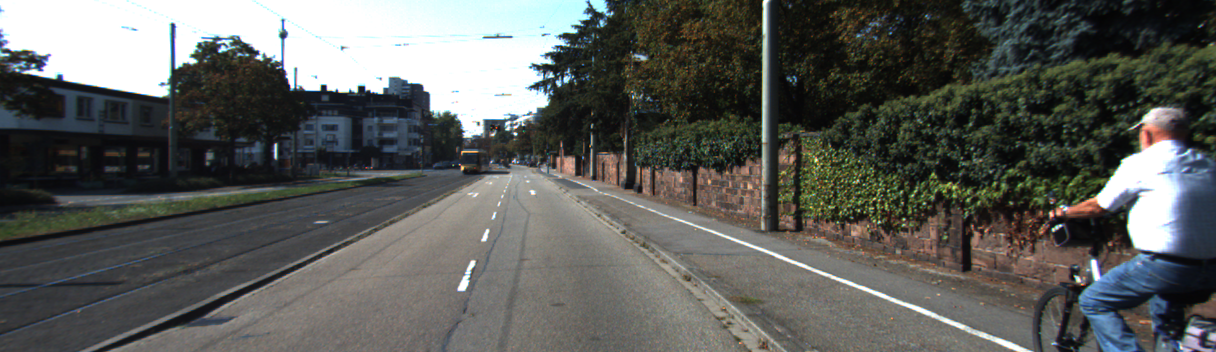

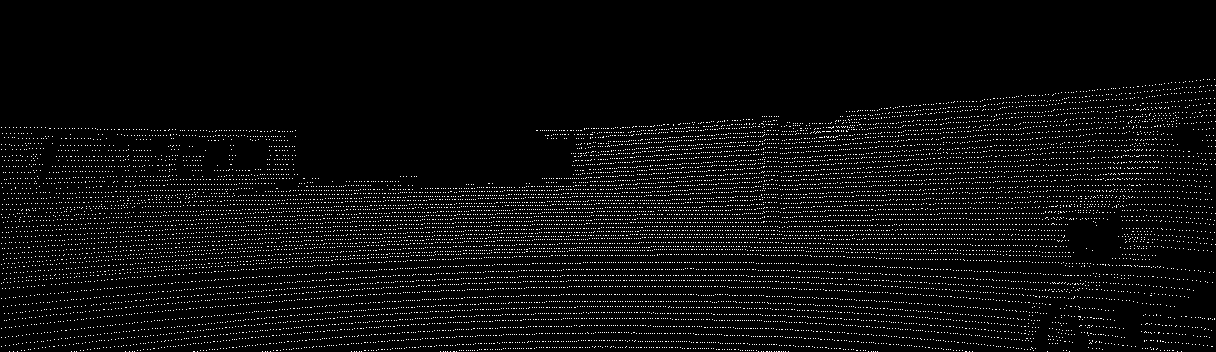

In [3]:

import PIL.Image
# Display input image #7
display(Image(filename=input_img_paths[7]))

# Display auto-contrast version of corresponding target (per-pixel categories)
that = ImageOps.autocontrast(load_img(target_img_paths[7]))
display(that)


In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [4]:
def prepare(batch_size, time_step ,img_size, input_img_paths, target_img_paths):
        for idx in range(len(input_img_paths)):
            i = idx * batch_size
            batch_input_img_paths = input_img_paths[i : i + batch_size]
            batch_target_img_paths = target_img_paths[i : i + batch_size]
            x = np.zeros((batch_size,)+ (time_step,) + img_size + (3,), dtype="float32")
            for j, path in enumerate(batch_input_img_paths):
                img = load_img(path, target_size=img_size)
                x[j] = img
            y = np.zeros((batch_size,)+(time_step,) + img_size + (1,), dtype="float32")
            for j, path in enumerate(batch_target_img_paths):
                img = load_img(path, target_size=img_size, color_mode="grayscale")
                y[j] = np.expand_dims(img, 2)
                #print(y.shape)
                #print (y)
                # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
                #y[j] -= 1
        #print(f'x: {x}')  
        #print(f'y: {y}')     
        return x,y

In [5]:
x, y= prepare(20, 3, img_size, input_img_paths, target_img_paths)
x.shape
#x_train= np.reshape(20,3,img_size, input_img_paths, target_img_paths)(x)
#y_train= np.reshape(20,3,img_size, input_img_paths, target_img_paths)(y)

(20, 3, 256, 256, 3)

In [16]:

from keras.activations import hard_sigmoid, relu
from keras.layers import Conv2D, Concatenate, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers import ConvLSTM2D
from tensorflow.keras import layers
from keras.layers import Layer
#from keras.layers import BatchNormalization
from numpy import reshape, true_divide
import tensorflow as tf

#encoder
#convolutional- lstm layers

#inp = layers.Input(shape=(None, *x_train.shape[2:]))
inp = keras.Input(shape=(3,256,256,3),
    batch_size=20)

print(inp.shape)




class ReshapeLayer(Layer):
    def call(self,inputs):
        nshape = (20,3) + inputs.shape[1:]
        return tf.reshape(inputs,nshape)

def decon(filter, stride): 
    return Conv2DTranspose(filters=filter, kernel_size=(3,3), strides=(stride,stride),padding='same', activation= relu)

def con(filter, stride):
    return Conv2D(filters=filter, kernel_size=(3,3), strides= (stride,stride),padding= 'same')

#input_image = Input(shape=(frames, channels, width, height))

input_ = inp

def depthnet(): 

    cnvlstm1= ConvLSTM2D(32, kernel_size=(7,7), strides=1, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(input_) #32
    skip1 = tf.reshape (cnvlstm1,(-1,256,256,32))
    #nm1=BatchNormalization(cnvlstm1)
    #print(f'first shape: {cnvlstm1.shape}')
    cnvlstm2= ConvLSTM2D(64, kernel_size=(5,5), strides=2, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm1) #64
    #print(f'second shape: {cnvlstm2.shape}')
    cnvlstm3= ConvLSTM2D(64, kernel_size=(5,5), strides=1, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm2) #64
    #print(f'third shape: {cnvlstm3.shape}')
    skip3 = tf.reshape (cnvlstm3,(-1,128,128,64))
    #nm2=BatchNormalization(cnvlstm3)
    cnvlstm4= ConvLSTM2D(128, kernel_size=(3,3), strides=2, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm3) #128
    print(f'4ht shape: {cnvlstm4.shape}')
    cnvlstm5= ConvLSTM2D(128, kernel_size=(3,3), strides=1, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm4) #128
    print(f'5th shape: {cnvlstm5.shape}')
    skip5 = tf.reshape (cnvlstm5,(-1,64,64,128))
    #nm3=BatchNormalization(cnvlstm5)
    cnvlstm6= ConvLSTM2D(256, kernel_size=(3,3), strides=2, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm5) #256
    print(f'6th shape: {cnvlstm6.shape}')
    skip6 = tf.reshape (cnvlstm6,(-1,32,32,256))
    cnvlstm7= ConvLSTM2D(256, kernel_size=(3,3), strides=1, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm6)#256
    print(f'7th shape: {cnvlstm7.shape}')
    #nm4=BatchNormalization(cnvlstm7)
    cnvlstm8= ConvLSTM2D(512, kernel_size=(3,3), strides=2, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm7)#512
    print(f'8th shape: {cnvlstm8.shape}')
    cnvlstm8= tf.reshape (cnvlstm8,(-1,16,16,512))
    print(f'cnvlstm8 shape: {cnvlstm8.shape}')
    #cnvlstm8=BatchNormalization(axis=1)(cnvlstm8)
    #decoder 
    dec1=  decon(512,1)(cnvlstm8)
    print(f'dec1 shape: {dec1.shape}')
    
    conc1= Concatenate()( [dec1 , cnvlstm8])
    print(f'concat1 shape: {conc1.shape}')
    conv1= con(512,1)(conc1)
    #print(f'conv1 shape: {conv1.shape}')
    #nm6= BatchNormalization(conv1)

    dec2=  decon(256,2)(conv1)
    dec2= decon(256,1)(dec2)
    print(f'dec2 shape: {dec2.shape}')
    conc2= Concatenate()( [dec2 , skip6])
    conv2= con(256,1)(conc2)
    print(f'conv2 shape: {conv2.shape}')
    #nm7= BatchNormalization(conv2)

    dec3=  decon(128,2)(conv2)
    dec3=  decon(128,1)(dec3)
    print(f'dec3 shape: {dec3.shape}')
    conc3= Concatenate()( [dec3 , skip5])
    conv3= con(128, 1)(conc3)
    print(f'conv3: {conv3.shape}')
    #nm6= BatchNormalization(conv3)

    dec4=  decon(64,2)(conv3)
    dec4=  decon(64,1)(dec4)
    print(f'dec4: {dec4.shape}')
    conc4= Concatenate()( [dec4 , skip3])
    print(f'conc4: {conc4.shape}')
    conv4= con(64, 1)(conc4)
    print(f'conv4: {conv4.shape}')
    #nm6= BatchNormalization(conv4)

    dec5=  decon(32,2)(conv4)
    dec5=  decon(32,1)(dec5)
    print(f'dec5: {dec5.shape}')
    conc5= Concatenate()( [dec5 , skip1])
    print(f'conc5: {conc5.shape}')
    conv5= con(32, 1)(conc5)
    print(f'conv5: {conv5.shape}')
    #conv5= BatchNormalization(conv5)
    
    dep = Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    print(f'dep: {dep.shape}')
    out = ReshapeLayer()(dep)
    #out = Reshape (-1,256,256,1) (dep)
    print(f'out: {out.shape}')
    net_model = keras.Model(inputs= [input_] , outputs= [out])
    net_model.summary()
    return net_model

(20, 3, 256, 256, 3)


In [17]:
# Compile
from keras import metrics
from keras import backend as K
model = depthnet()

def custom_loss_function(target, output):

    first_log = K.log(K.clip(output, K.epsilon(), np.inf) + 1.)
    second_log = K.log(K.clip(target, K.epsilon(), np.inf) + 1.)
    print(f'log output: {first_log.shape}')
    print(f'log target: {second_log.shape}')
    loss= K.mean(K.square(first_log - second_log), axis=-1) - 0.5 * K.square(K.mean(first_log - second_log, axis=-1))
    
    #di = output - target
    #di = tf.math.log(output) - tf.math.log(target)
    #n = (64 * 64)
    #di2 = tf.math.pow(di, 2)
    #fisrt_term = tf.reduce_sum(di2)/n
    #second_term = 0.5*tf.math.pow(tf.reduce_sum(di), 2)/ (n**2)
    #loss = fisrt_term - second_term
    return loss

#model.compile(optimizer=tf.keras.optimizers.Adam(),
                  #loss="sparse_categorical_crossentropy")
                  
model.compile(loss=custom_loss_function, optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=metrics.mean_absolute_error)
#model.compile(loss=keras.losses.BinaryCrossentropy, optimizer='adam', metrics=[metrics.RootMeanSquaredError, metrics.MeanSquaredLogarithmicError])
epochs = 20
#batch_size = 4

# Fit the model to the training data.
model.fit(x, y,
    #batch_size=batch_size,
    epochs=epochs)

4ht shape: (20, 3, 64, 64, 128)
5th shape: (20, 3, 64, 64, 128)
6th shape: (20, 3, 32, 32, 256)
7th shape: (20, 3, 32, 32, 256)
8th shape: (20, 3, 16, 16, 512)
cnvlstm8 shape: (60, 16, 16, 512)
dec1 shape: (60, 16, 16, 512)
concat1 shape: (60, 16, 16, 1024)
dec2 shape: (60, 32, 32, 256)
conv2 shape: (60, 32, 32, 256)
dec3 shape: (60, 64, 64, 128)
conv3: (60, 64, 64, 128)
dec4: (60, 128, 128, 64)
conc4: (60, 128, 128, 128)
conv4: (60, 128, 128, 64)
dec5: (60, 256, 256, 32)
conc5: (60, 256, 256, 64)
conv5: (60, 256, 256, 32)
dep: (60, 256, 256, 1)
out: (20, 3, 256, 256, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(20, 3, 256, 256,   0           []                               
                                3)]                                                               
         